In [1]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from os import listdir, path
from random import sample, choice
from string import punctuation
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import pickle
import sys

In [2]:
CAPTIONS_FILE_LOC = "captions.token"
SPLIT_FILE_LOC = "split.pickle"
OG_CAPTIONS_DICT_FILE_LOC = "captions_dict.pickle"
CAPTIONS_DICT_FILE_LOC = "captions_stemmed_dict.pickle"
OG_CAPTION_DICT_FILE_LOC = "captions_dict.pickle"
TOKENIZER_FILE_LOC = "tokenizer_one_hot.pickle"
INCEPTION_FEAT_FILE_LOC = "inception_v3_output.pickle"

DATASET_DIR = "./flickr30k-images/"

In [3]:
# Parameters
IMAGE_SIZE = 256
MARGIN = 0.7
BATCH_SIZE = 32
EMBEDDING_OUT_LENGTH = 128

In [4]:
en_stopwords = stopwords.words("english")

In [5]:
def prepare_tokenizer(caption_file_location=CAPTIONS_FILE_LOC, override=False):
    if path.exists(TOKENIZER_FILE_LOC) and not override:
        return pickle.load(open(TOKENIZER_FILE_LOC, "rb"))
    caption_file = open(caption_file_location, "r", encoding="utf-8")
    captions = []
    tokenizer = Tokenizer()
    snowball_stemmer = SnowballStemmer("english")
    for line in tqdm(caption_file.readlines()):
        line = line.split()
        caption = [snowball_stemmer.stem(word.lower()) for word in line[1:] if word.lower() not in en_stopwords and word.lower() not in punctuation]
        captions.append(caption)
    tokenizer.fit_on_texts(captions)
    pickle.dump(tokenizer, open(TOKENIZER_FILE_LOC, "wb"))
    return tokenizer

In [6]:
tokenizer = prepare_tokenizer()

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

13388


In [8]:
def prepare_caption_dict(caption_file_location=CAPTIONS_FILE_LOC, override=False):
    if path.exists(CAPTIONS_DICT_FILE_LOC) and not override:
        return pickle.load(open(CAPTIONS_DICT_FILE_LOC, "rb"))
    caption_file = open(caption_file_location, "r", encoding="utf-8")  
    caption_dict = {}
    snowball_stemmer = SnowballStemmer("english")
    for line in tqdm(caption_file.readlines()):
        line = line.split()
        head = line[0].split(".")
        label = head[0]
        index = int(head[1].split("#")[1])
        tail = [snowball_stemmer.stem(word.lower()) for word in line[1:] if word.lower() not in en_stopwords and word.lower() not in punctuation]
        if caption_dict.get(label, None) is None:
            caption_dict[label] = {}
        caption_dict[label][index] = tail
    pickle.dump(caption_dict, open(CAPTIONS_DICT_FILE_LOC, "wb"))
    return caption_dict

In [9]:
captions_dict = prepare_caption_dict()

In [10]:
og_caption_dict = pickle.load(open(OG_CAPTION_DICT_FILE_LOC, "rb"))

In [11]:
splits = pickle.load(open(SPLIT_FILE_LOC, "rb"))

In [12]:
inception_v3_feats = pickle.load(open(INCEPTION_FEAT_FILE_LOC, "rb"))

In [13]:
def prepare_image(image_path, image_size=IMAGE_SIZE):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    return image / 255.

In [14]:
def triplet_ranking_loss(image_pred, text_pred, margin=MARGIN):
    n = image_pred.shape[0]

    im_loss = 0.0
    for i in range(n):
        im_pos_sim = tf.keras.backend.sum(tf.multiply(image_pred[i], text_pred[i]))
        for j in range(n):
            if i == j:
                continue
            im_neg_sim = tf.keras.backend.sum(tf.multiply(image_pred[i], text_pred[j]))
            im_loss += tf.maximum(0, im_neg_sim - im_pos_sim + margin)
    
    txt_loss = 0.0
    for i in range(n):
        txt_pos_sim = tf.keras.backend.sum(tf.multiply(image_pred[i], text_pred[i]))
        for j in range(n):
            if i == j:
                continue
            txt_neg_sim = tf.keras.backend.sum(tf.multiply(image_pred[j], text_pred[i]))
            txt_loss += tf.maximum(0, txt_neg_sim - txt_pos_sim + margin)
    
    loss = im_loss + txt_loss
    return loss / n

In [15]:
def prepare_image_batch(samples, im_size=IMAGE_SIZE):
    im_batch = np.zeros((len(samples), im_size, im_size, 3))
    for i in range(len(samples)):
        im_batch[i] = prepare_image(DATASET_DIR + samples[i] + ".jpg", im_size)
    return im_batch

In [16]:
def prepare_image_feat_batch(samples):
    im_batch = np.zeros((len(samples), 2048))
    for i in range(len(samples)):
        im_batch[i] = inception_v3_feats[samples[i]]
    return im_batch

In [17]:
def prepare_text_batch_one_hot(samples):
    captions = []
    for i in range(len(samples)):
        random_index = sample([0, 1, 2, 3, 4], 1)[0]
        captions.append(captions_dict[samples[i]][random_index])
    encoded_captions = tokenizer.texts_to_matrix(captions, mode="count")
    return encoded_captions

In [18]:
# test_image_batch = prepare_image_batch(sample(splits["train"], 64))

In [19]:
# plt.imshow(test_image_batch[0])

In [139]:
# IMAGE_SIZE = 256

# inception_v3_model = InceptionV3(
#     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
#     include_top = False, 
#     weights = 'imagenet'
# )
# inception_output = inception_v3_model.output
# x = layers.GlobalAveragePooling2D()(inception_output)

# inception_model = Model(inception_v3_model.input, x)

In [ ]:
# in_v3_feats = {}

# for label in tqdm(splits["train"] + splits["val"] + splits["test"]):
#     in_v3_feats[label] = inception_model(np.array([prepare_image(DATASET_DIR + label + ".jpg", 256)]))[0]

# pickle.dump(in_v3_feats, open(INCEPTION_FEAT_FILE_LOC, "wb"))

In [20]:
# inception_v3_feats["1000092795"]

In [39]:
# image_model = Sequential()
# image_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# image_model.add(layers.MaxPooling2D((2, 2)))
# image_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# image_model.add(layers.MaxPooling2D((2, 2)))
# image_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# image_model.add(layers.Flatten())
# image_model.add(layers.Dense(512, activation='relu'))
# image_model.add(layers.Dense(256, activation='relu'))
# image_model.add(layers.Dense(EMBEDDING_OUT_LENGTH))
# image_model.add(layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1)))

image_model = Sequential()
image_model.add(tf.keras.Input(shape=(2048,)))
image_model.add(layers.Dense(512, activation="relu"))
image_model.add(layers.Dense(256, activation="relu"))
image_model.add(layers.Dense(EMBEDDING_OUT_LENGTH))
image_model.add(layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1)))

In [40]:
text_model = Sequential()
text_model.add(layers.Input(vocab_size,))
text_model.add(layers.Dense(512, activation='relu'))
text_model.add(layers.Dense(256, activation='relu'))
text_model.add(layers.Dense(EMBEDDING_OUT_LENGTH))
text_model.add(layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1)))

In [41]:
np.sum(text_model(prepare_text_batch_one_hot(sample(splits["train"], 64)))[0] ** 2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



0.9999999

In [42]:
def calculate_loss_and_gradient(image_input, text_input, image_model=image_model, text_model=text_model, margin=MARGIN):
    with tf.GradientTape() as image_tape, tf.GradientTape() as text_tape:
        image_tensor = tf.convert_to_tensor(image_input)
        text_tensor = tf.convert_to_tensor(np.array(text_input, dtype=np.float32))
        image_tape.watch(image_tensor)
        text_tape.watch(text_tensor)
        image_tensor = image_input
        text_tensor = text_input
        image_pred = image_model(image_tensor, training=True)
        text_pred = text_model(text_tensor, training=True)
        loss = triplet_ranking_loss(image_pred, text_pred, margin)
        image_grad = image_tape.gradient(loss, image_model.trainable_variables)
        text_grad = text_tape.gradient(loss, text_model.trainable_variables)
        return loss, image_grad, text_grad

In [43]:
optimizer = tf.optimizers.Adam(lr=0.001)

In [44]:
train_losses = []
val_losses = []

In [45]:
MARGIN = 0.5
ITERATIONS = 500
BATCH_SIZE = 64
IMAGE_SIZE = 128

for i in range(ITERATIONS):
    train_samples = sample(splits["train"], BATCH_SIZE)
    # train_image_batch = prepare_image_feat_batch(train_samples, IMAGE_SIZE)
    train_image_batch = prepare_image_feat_batch(train_samples)
    train_text_batch = prepare_text_batch_one_hot(train_samples)
    train_loss, image_grad, text_grad = calculate_loss_and_gradient(train_image_batch, train_text_batch, image_model, text_model, MARGIN)
    optimizer.apply_gradients(zip(image_grad, image_model.trainable_variables))
    optimizer.apply_gradients(zip(text_grad, text_model.trainable_variables))
    val_samples = sample(splits["val"], BATCH_SIZE)
    # val_image_batch = prepare_image_batch(val_samples, IMAGE_SIZE)
    val_image_batch = prepare_image_feat_batch(val_samples)
    val_text_batch = prepare_text_batch_one_hot(val_samples)
    val_image_pred = image_model(val_image_batch)
    val_text_pred = text_model(val_text_batch)
    val_loss = triplet_ranking_loss(val_image_pred, val_text_pred)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print("iteration:", (i+1), end=" ")
    tf.print("train_loss:", train_loss, "val_loss:", val_loss, output_stream=sys.stdout)

442169
iteration: 160 train_loss: 19.7485046 val_loss: 29.4072094
iteration: 161 train_loss: 18.9278488 val_loss: 35.7124443
iteration: 162 train_loss: 17.4919682 val_loss: 34.5207176
iteration: 163 train_loss: 21.3467293 val_loss: 28.2891846
iteration: 164 train_loss: 14.1554146 val_loss: 35.7126389
iteration: 165 train_loss: 19.8128376 val_loss: 30.661869
iteration: 166 train_loss: 14.5839949 val_loss: 29.3619156
iteration: 167 train_loss: 18.0394707 val_loss: 33.6117783
iteration: 168 train_loss: 16.231348 val_loss: 33.0795975
iteration: 169 train_loss: 14.7266827 val_loss: 27.8223228
iteration: 170 train_loss: 16.913765 val_loss: 27.4424152
iteration: 171 train_loss: 18.100172 val_loss: 33.253334
iteration: 172 train_loss: 18.9062157 val_loss: 28.4003334
iteration: 173 train_loss: 14.9423161 val_loss: 32.3899155
iteration: 174 train_loss: 15.2575464 val_loss: 28.5764046
iteration: 175 train_loss: 15.847496 val_loss: 30.6408367
iteration: 176 train_loss: 14.0550613 val_loss: 32.9305

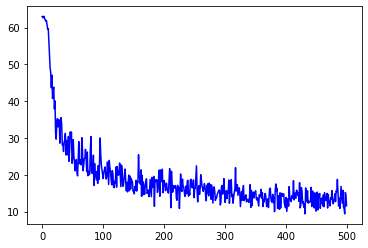

In [46]:
plt.plot(train_losses, color='blue')

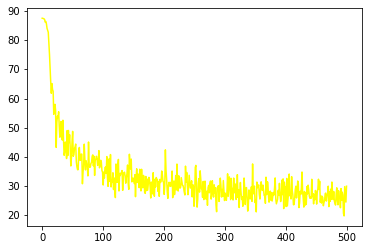

In [47]:
plt.plot(val_losses, color='yellow')

In [48]:
# image_model.save("./models/image_model_1h_v1.h5")
# text_model.save("./models/text_model_1h_v1.h5")

# losses = {
#     "train": train_losses,
#     "val": val_losses
# }
# pickle.dump(losses, open("./losses/losses_1h_v1.pickle", "wb"))

In [21]:
image_model = load_model("./models/image_model_1h_v1.h5")
text_model = load_model("./models/text_model_1h_v1.h5")

In [22]:
test_inputs = np.zeros((len(splits["test"]), 2048))
for i, label in enumerate(splits["test"]):
    test_inputs[i] = inception_v3_feats[label]
test_image_outputs = image_model.predict(test_inputs)
del test_inputs
reference_outs = {}
for i, label in enumerate(splits["test"]):
    reference_outs[label] = test_image_outputs[i]

In [170]:
# text_query = "people are running .".split()
test_label = choice(splits["test"])
test_index = choice([0,1,2,3,4])
text_query = captions_dict[test_label][test_index]
print(test_label, test_index)
print("Ground truth caption:", og_caption_dict[test_label][test_index])
print("Stemmed caption:", text_query)
tokenized = tokenizer.texts_to_matrix([text_query], mode="count")
text_output = text_model.predict(tokenized)
sims = []
for label in reference_outs:
    sims.append([np.sum(text_output * reference_outs[label]), label])
sims.sort(reverse=True)
for pos, result in enumerate(sims):
    if sims[pos][1] == test_label:
        print("Position in results:", (pos+1))
        break

2984174290 4
Ground truth caption: ['the', 'surfer', 'is', 'in', 'the', 'wave', '.']
Stemmed caption: ['surfer', 'wave']
Position in results: 7


In [171]:
sims[:10]

[[0.9351201, '2949337912'],
 [0.9284969, '2622624460'],
 [0.9212991, '2842439618'],
 [0.91662246, '3640329164'],
 [0.916364, '7249187716'],
 [0.9069271, '3421131122'],
 [0.9039675, '2984174290'],
 [0.8964863, '2671602981'],
 [0.8937066, '33497646'],
 [0.8863343, '6381062375']]

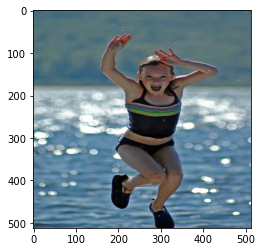

In [172]:
plt.imshow(prepare_image(DATASET_DIR + sims[7][1] + ".jpg", 512))

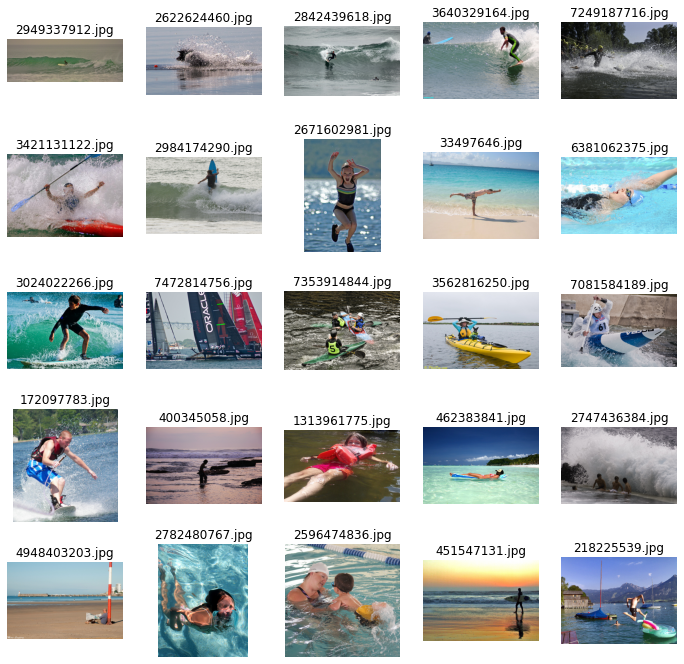

In [173]:
rows = 5
columns = 5
fig=plt.figure(figsize=(12,12))
for i in range(1, 26):
  label = sims[i-1][1]
  img = Image.open(DATASET_DIR + label + '.jpg')
  axes = fig.add_subplot(rows, columns, i)
  axes.set_autoscale_on(True)
  axes.set_title(label + '.jpg')
  axes.axis('off')
  plt.imshow(img)
plt.show()

In [23]:
def plot_random_text_caption_results():
    test_label = choice(splits["test"])
    test_index = choice([0,1,2,3,4])
    text_query = captions_dict[test_label][test_index]
    print(test_label, test_index)
    print("Ground truth caption:", og_caption_dict[test_label][test_index])
    print("Stemmed caption:", text_query)
    tokenized = tokenizer.texts_to_matrix([text_query], mode="count")
    text_output = text_model.predict(tokenized)
    sims = []
    for label in reference_outs:
        sims.append([np.sum(text_output * reference_outs[label]), label])
    sims.sort(reverse=True)

    for pos, result in enumerate(sims):
        if sims[pos][1] == test_label:
            print("Position in results:", (pos+1))
            break

    rows = 4
    columns = 4
    fig=plt.figure(figsize=(12,12))
    for i in range(1, 17):
        label = sims[i-1][1]
        img = Image.open(DATASET_DIR + label + '.jpg')
        axes = fig.add_subplot(rows, columns, i)
        axes.set_autoscale_on(True)
        axes.set_title(label + '.jpg')
        axes.axis('off')
        plt.imshow(img)
    plt.show()

6925158300 2
Ground truth caption: ['there', 'is', 'a', 'line', 'of', 'computers', 'in', 'a', 'row', 'and', 'each', 'one', 'is', 'occupied', 'by', 'a', 'man', '.']
Stemmed caption: ['line', 'comput', 'row', 'one', 'occupi', 'man']
Position in results: 1


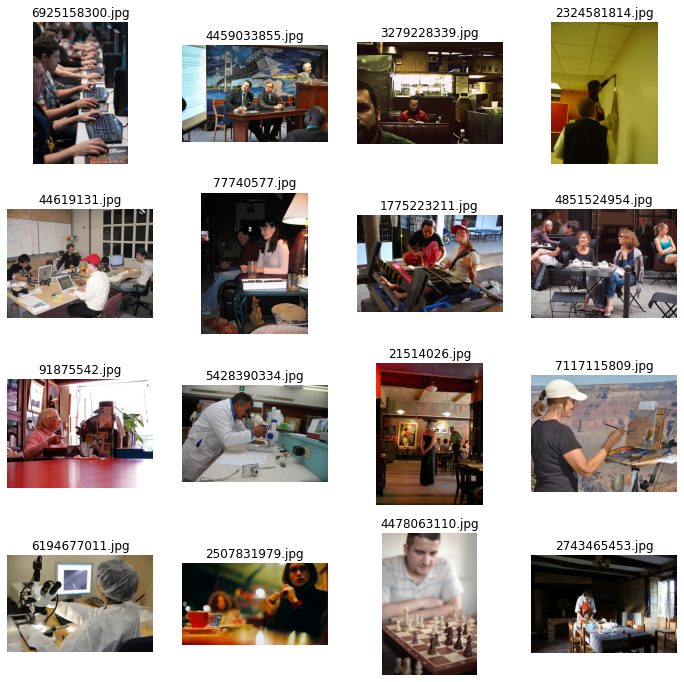

In [165]:
plot_random_text_caption_results()

In [161]:
def plot_query_results(query):
    test_label = choice(splits["test"])
    test_index = choice([0,1,2,3,4])
    text_query = query.split()
    snowball_stemmer = SnowballStemmer("english")
    stemmed_caption = [snowball_stemmer.stem(word.lower()) for word in text_query if word.lower() not in en_stopwords and word.lower() not in punctuation]
    print("Ground truth caption:", text_query)
    print("Stemmed caption:", stemmed_caption)
    tokenized = tokenizer.texts_to_matrix([stemmed_caption], mode="count")
    text_output = text_model.predict(tokenized)
    sims = []
    for label in reference_outs:
        sims.append([np.sum(text_output * reference_outs[label]), label])
    sims.sort(reverse=True)

    rows = 4
    columns = 4
    fig=plt.figure(figsize=(12,12))
    for i in range(1, 17):
        label = sims[i-1][1]
        img = Image.open(DATASET_DIR + label + '.jpg')
        axes = fig.add_subplot(rows, columns, i)
        axes.set_autoscale_on(True)
        axes.set_title(label + '.jpg')
        axes.axis('off')
        plt.imshow(img)
    plt.show()

Ground truth caption: ['People', 'walking', 'on', 'the', 'street']
Stemmed caption: ['peopl', 'walk', 'street']


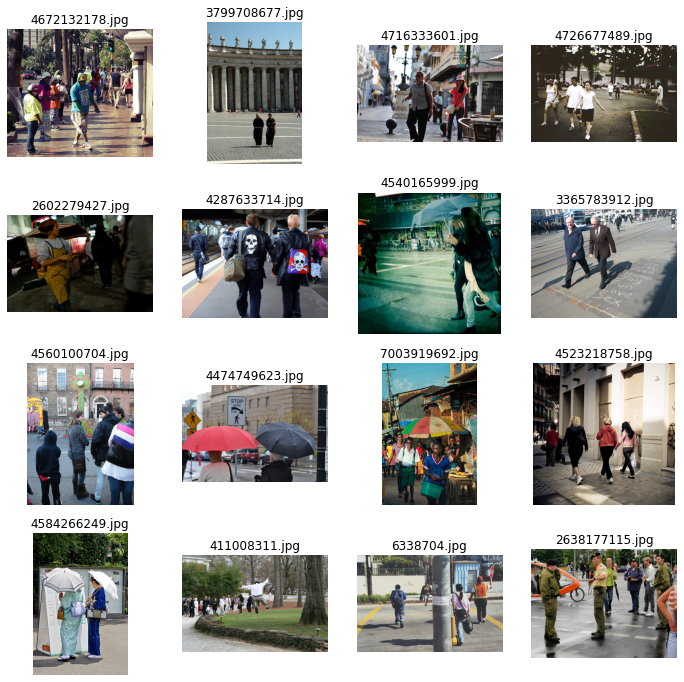

In [164]:
plot_query_results("People walking on the street")

44619131 1
Ground truth caption: ['four', 'people', ',', 'three', 'men', 'and', 'one', 'woman', ',', 'are', 'working', 'on', 'their', 'computers', '.']
Stemmed caption: ['four', 'peopl', 'three', 'men', 'one', 'woman', 'work', 'comput']
Position in results: 5


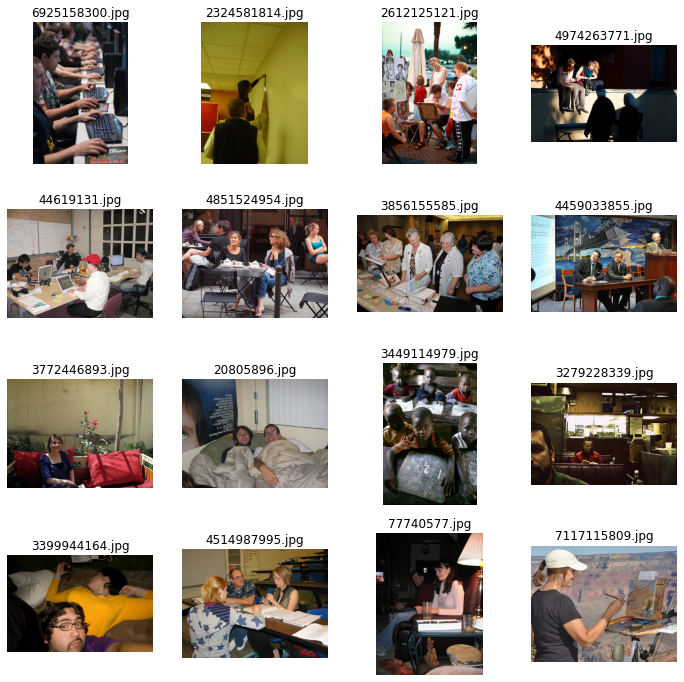

In [176]:
plot_random_text_caption_results()

4973611817 1
Ground truth caption: ['a', 'cop', 'in', 'a', 'blue', 'shirt', 'pulling', 'over', 'a', 'car', 'in', 'the', 'city', '.']
Stemmed caption: ['cop', 'blue', 'shirt', 'pull', 'car', 'citi']
Position in results: 4


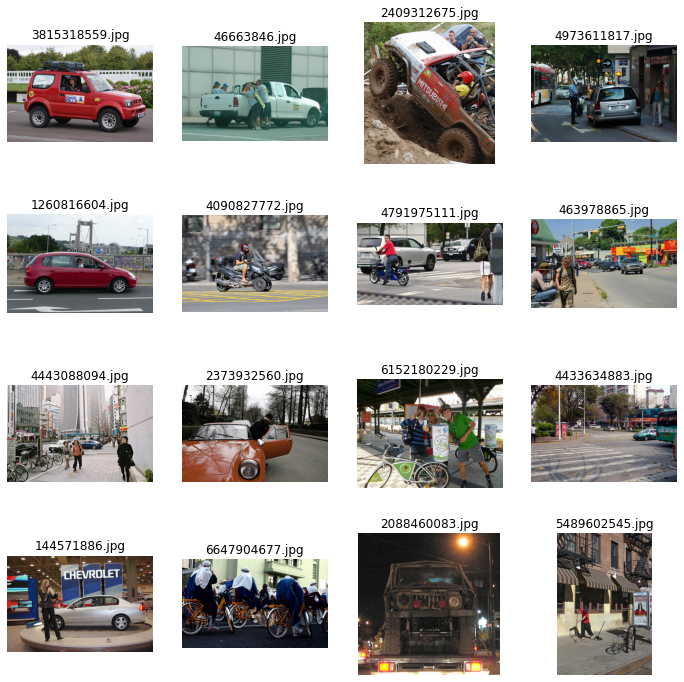

In [25]:
plot_random_text_caption_results()